# 1. Import library

In [1]:
import tensorflow as tf
from sklearn.utils import shuffle
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt

# 2. Declare function

In [2]:
# weight and bais wrappers
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W',
                           dtype=tf.float32,
                           shape=shape,
                           initializer=initer)

def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b',
                           dtype=tf.float32,
                           initializer=initial)


def conv_layer_02(x, filter_size=5, num_filters=6, stride=1, name='conv',ismaxpool=True):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :param ismaxpool: ismaxpool= True
    :return: The output array
    """
    with tf.variable_scope(name):
        #prepare
        num_in_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_in_channel, num_filters]
        # computing
        W = weight_variable(shape=shape)
        b = bias_variable(shape=[num_filters])
        conv = tf.nn.conv2d(x, W,
                             strides=[1, stride, stride, 1],
                             padding="SAME")+b
        act=tf.nn.relu(conv)
        
        # summary
        tf.summary.histogram('weight', W)
        tf.summary.histogram('bias', b)
        tf.summary.histogram('activation',act)
        # return
        if ismaxpool:
            return tf.nn.max_pool(act,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
        else:
            return act
#
def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat
#
def fc_layer_02(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_units: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        # prepare
        in_dim = x.get_shape()[1]
        # Computing
        W = weight_variable(shape=[in_dim, num_units])
        b = bias_variable(shape=[num_units])
        act = tf.matmul(x, W)+b
        # summary
        tf.summary.histogram('weight', W)
        tf.summary.histogram('bias', b)
        tf.summary.histogram('activation',act)
        # return
        if use_relu:
            act = tf.nn.relu(act)
        return act
#
def imshows(images,labels,map=[6,6],name='figure_name'):
    map=np.asarray(map)
    p=np.product(map)
    plt.figure(figsize=list(map*2))
    for i in range(p):
        plt.subplot(map[0],map[1],i+1)
        plt.imshow(images[i].squeeze())
        plt.title(str(labels[i]))
        plt.tick_params(labelbottom=False, labelleft=False)
    plt.suptitle(name)
    plt.show()

# 3. Load mnist dataset

In [3]:
# loading mnist dataset
mnist=tf.contrib.learn.datasets.mnist.read_data_sets(train_dir='data',reshape=False,one_hot=True)
# train
X_train=mnist.train.images
y_train=mnist.train.labels
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
# validation
X_valid=mnist.validation.images
y_valid=mnist.validation.labels
print(f'X_valid shape: {X_valid.shape}')
print(f'y_valid shape: {y_valid.shape}')
# test
X_test=mnist.test.images
y_test=mnist.test.labels
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data\t10k-images-idx3-ubyte.gz
Extracting data\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mn

# 3.1 showing the mnist dataset

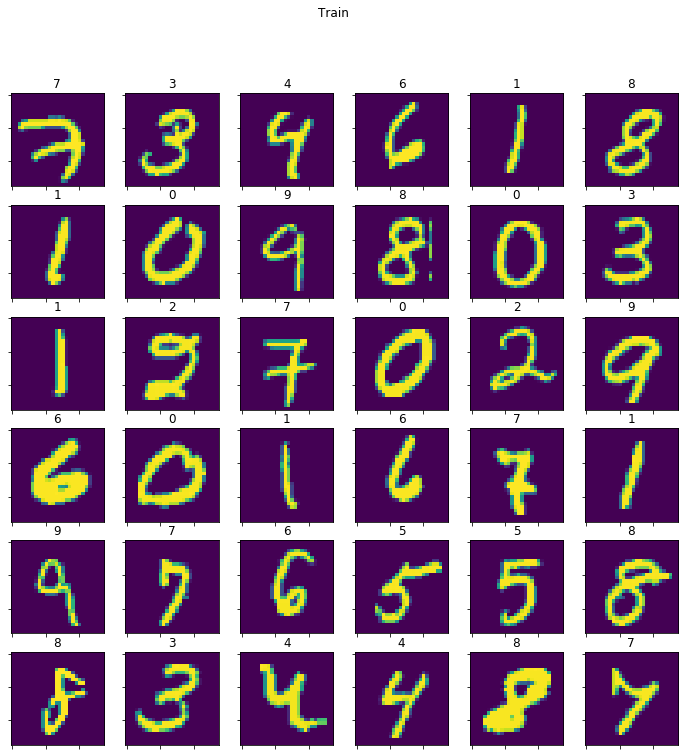

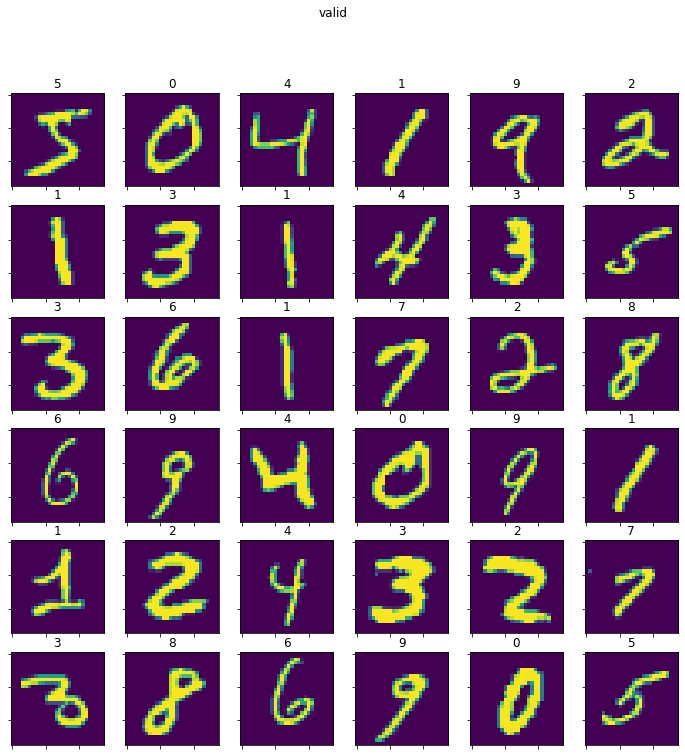

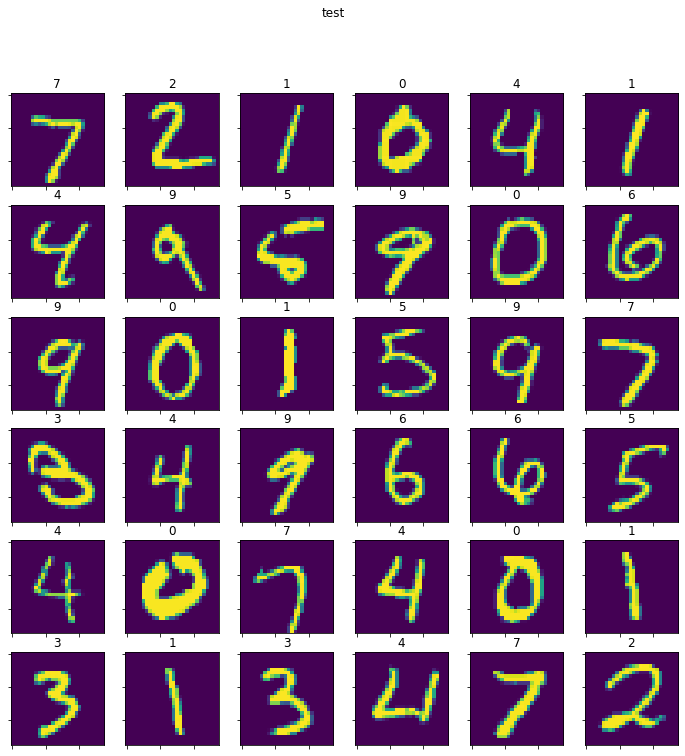

'\nX_train shape: (55000, 28, 28, 1)\ny_train shape: (55000, 10)\nX_valid shape: (5000, 28, 28, 1)\ny_valid shape: (5000, 10)\nX_test shape: (10000, 28, 28, 1)\ny_test shape: (10000, 10)\n'

In [4]:
flagshow=True
if flagshow:
    imshows(X_train,np.argmax(a=y_train,axis=1),map=[6,6],name='Train')
    imshows(X_valid,np.argmax(a=y_valid,axis=1),map=[6,6],name='valid')
    imshows(X_test,np.argmax(a=y_test,axis=1),map=[6,6],name='test')
'''
X_train shape: (55000, 28, 28, 1)
y_train shape: (55000, 10)
X_valid shape: (5000, 28, 28, 1)
y_valid shape: (5000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)
'''

# 4. define graph and training model

In [5]:
# config parameter
lr=0.001
logdir='.\\logdir'
epochs=10
batch_size=100
freq01=10
freq02=500
global_step=0
stopping_accuracy=0.98
def model():
    global global_step
    #
    tf.reset_default_graph()
    sess=tf.Session()
    #
    x=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1],name='x')
    tf.summary.image(name='x',tensor=x,max_outputs=3,collections=None,family=None)
    y=tf.placeholder(dtype=tf.float32,shape=[None,10],name='y')
    conv1=conv_layer_02(x,filter_size=5,num_filters=6,stride=1,name='conv1',ismaxpool=True)
    conv2=conv_layer_02(conv1,filter_size=5,num_filters=16,stride=1,name='conv2',ismaxpool=True)
    flatted=flatten_layer(conv2)
    fc1=fc_layer_02(x=flatted,num_units=120,name='fc1',use_relu=True)
    fc2=fc_layer_02(x=fc1,num_units=84,name='fc2',use_relu=True)
    logits=fc_layer_02(x=fc2,num_units=10,name='logits',use_relu=False)
    #
    with tf.variable_scope('Train'):
        with tf.variable_scope('Loss'):
            loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=logits),name='loss')
            tf.summary.scalar(name='sum_loss',tensor=loss,collections=None,family=None)
        with tf.variable_scope('Optimizer'):
            optimizer=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
        with tf.variable_scope('Accuracy'):
            correct_prediction=tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
            accuracy=tf.reduce_mean(tf.cast(x=correct_prediction,dtype=tf.float32,name='Accuracy'))
            tf.summary.scalar(name='sum_accuracy',tensor=accuracy,collections=None,family=None)
    #
    summary=tf.summary.merge_all()
    sess.run(tf.global_variables_initializer())
    saver=tf.train.Saver()
    #
    tmp_time=datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    writer_train=   tf.summary.FileWriter(os.path.join(logdir,'model01',tmp_time,'train'))
    writer_train.add_graph(sess.graph)
    #
    writer_valid=   tf.summary.FileWriter(os.path.join(logdir,'model01',tmp_time,'valid'))
    writer_valid.add_graph(sess.graph)
    #
    writer_test=    tf.summary.FileWriter(os.path.join(logdir,'model01',tmp_time,'test'))
    writer_test.add_graph(sess.graph)
    #
    num_iteration=int(len(y_train)/batch_size)+1
    # training
    for epoch in range(epochs):
        print(f'Training epoch:\t{epoch+1}/{epochs}')
        # step 01: randomization train dataset
        X_train2,y_train2=shuffle(X_train,y_train)
        #
        for iteration in range(num_iteration):
            # calculate batch size
            global_step+=1
            start=iteration*batch_size
            end=(iteration+1)*batch_size
            X_batch=X_train2[start:end]
            y_batch=y_train2[start:end]
            
            feeddict_batch={x:X_batch,y:y_batch}
            #Optimizing training (backforward)
            sess.run(optimizer,feed_dict=feeddict_batch)
            #
            if iteration % freq01 == 0:
                # Calculate, display and write to summary the batch loss and accuracy
                [accuracy_batch,loss_batch,summary_batch]=sess.run([accuracy,loss,summary],feed_dict=feeddict_batch)
                writer_train.add_summary(summary=summary_batch, global_step=global_step)
                print(f'Epoch {epoch+1}\t Train:\t gstep: {global_step}\t iter: {iteration}\t Acc: {accuracy_batch}\t Loss: {loss_batch}')
            if iteration % freq02 == 0:
                # save the model checkpoint per 500 iteration
                saver.save(sess,os.path.join(logdir, f"checkpoint/model_checkpoint_{iteration}"))          
                
        # Run validation after every epoch
        [accuracy_valid,loss_valid, summary_valid]=  sess.run([accuracy,loss,summary],feed_dict={x:X_valid, y:y_valid})
        [accuracy_test, loss_test,  summary_test]=   sess.run([accuracy,loss,summary],feed_dict={x:X_test,  y:y_test})
        writer_valid.add_summary(   summary=   summary_valid,   global_step=global_step)
        writer_test.add_summary(   summary=    summary_test,   global_step=global_step)
        print('---'*10)
        print(f'Epoch {epoch+1}\t Valid:\t gstep: {global_step}\t iter: {iteration}\t Acc: {accuracy_valid}\t Loss: {loss_valid}')
        print(f'Epoch {epoch+1}\t test:\t gstep: {global_step}\t iter: {iteration}\t Acc: {accuracy_test}\t Loss: {loss_test}')
        print('---'*10)
        if accuracy_valid>stopping_accuracy:
            print('breaking')
            break
    # save the final model checkpoint when finish traininng
    saver.save(sess=sess,save_path=os.path.join(logdir,'checkpoint/model_checkpoint_final'))
    print('Training Done')  
    temp_path=os.getcwd()+'\\logdir'
    print(f'tensorboard --logdir={temp_path}')
    sess.close()

In [6]:
# Training
model()

Training epoch:	1/10
Epoch 1	 Train:	 gstep: 1	 iter: 0	 Acc: 0.12999999523162842	 Loss: 2.3023722171783447
Epoch 1	 Train:	 gstep: 11	 iter: 10	 Acc: 0.14000000059604645	 Loss: 2.3033058643341064
Epoch 1	 Train:	 gstep: 21	 iter: 20	 Acc: 0.10999999940395355	 Loss: 2.299311637878418
Epoch 1	 Train:	 gstep: 31	 iter: 30	 Acc: 0.11999999731779099	 Loss: 2.2434804439544678
Epoch 1	 Train:	 gstep: 41	 iter: 40	 Acc: 0.23000000417232513	 Loss: 2.099579095840454
Epoch 1	 Train:	 gstep: 51	 iter: 50	 Acc: 0.3700000047683716	 Loss: 1.8793905973434448
Epoch 1	 Train:	 gstep: 61	 iter: 60	 Acc: 0.46000000834465027	 Loss: 1.5477300882339478
Epoch 1	 Train:	 gstep: 71	 iter: 70	 Acc: 0.6499999761581421	 Loss: 1.1362390518188477
Epoch 1	 Train:	 gstep: 81	 iter: 80	 Acc: 0.6100000143051147	 Loss: 1.0257738828659058
Epoch 1	 Train:	 gstep: 91	 iter: 90	 Acc: 0.6899999976158142	 Loss: 0.8165445923805237
Epoch 1	 Train:	 gstep: 101	 iter: 100	 Acc: 0.7300000190734863	 Loss: 1.040034532546997
Epoch 1	

Epoch 2	 Train:	 gstep: 882	 iter: 330	 Acc: 0.8899999856948853	 Loss: 0.2728201448917389
Epoch 2	 Train:	 gstep: 892	 iter: 340	 Acc: 0.9100000262260437	 Loss: 0.21375185251235962
Epoch 2	 Train:	 gstep: 902	 iter: 350	 Acc: 0.9700000286102295	 Loss: 0.10116865485906601
Epoch 2	 Train:	 gstep: 912	 iter: 360	 Acc: 0.9399999976158142	 Loss: 0.16930587589740753
Epoch 2	 Train:	 gstep: 922	 iter: 370	 Acc: 0.9399999976158142	 Loss: 0.20887483656406403
Epoch 2	 Train:	 gstep: 932	 iter: 380	 Acc: 0.9800000190734863	 Loss: 0.10869041085243225
Epoch 2	 Train:	 gstep: 942	 iter: 390	 Acc: 0.9800000190734863	 Loss: 0.08495310693979263
Epoch 2	 Train:	 gstep: 952	 iter: 400	 Acc: 0.9800000190734863	 Loss: 0.08109069615602493
Epoch 2	 Train:	 gstep: 962	 iter: 410	 Acc: 0.9300000071525574	 Loss: 0.14880356192588806
Epoch 2	 Train:	 gstep: 972	 iter: 420	 Acc: 0.9900000095367432	 Loss: 0.053661420941352844
Epoch 2	 Train:	 gstep: 982	 iter: 430	 Acc: 0.9700000286102295	 Loss: 0.06595701724290848

Epoch 4	 Train:	 gstep: 1724	 iter: 70	 Acc: 0.9700000286102295	 Loss: 0.1220017820596695
Epoch 4	 Train:	 gstep: 1734	 iter: 80	 Acc: 0.9800000190734863	 Loss: 0.03302015736699104
Epoch 4	 Train:	 gstep: 1744	 iter: 90	 Acc: 0.9700000286102295	 Loss: 0.0831703394651413
Epoch 4	 Train:	 gstep: 1754	 iter: 100	 Acc: 0.9800000190734863	 Loss: 0.05651669204235077
Epoch 4	 Train:	 gstep: 1764	 iter: 110	 Acc: 0.9800000190734863	 Loss: 0.07122466713190079
Epoch 4	 Train:	 gstep: 1774	 iter: 120	 Acc: 0.9700000286102295	 Loss: 0.0757421925663948
Epoch 4	 Train:	 gstep: 1784	 iter: 130	 Acc: 0.9700000286102295	 Loss: 0.11326618492603302
Epoch 4	 Train:	 gstep: 1794	 iter: 140	 Acc: 0.9599999785423279	 Loss: 0.13182128965854645
Epoch 4	 Train:	 gstep: 1804	 iter: 150	 Acc: 0.9700000286102295	 Loss: 0.13178473711013794
Epoch 4	 Train:	 gstep: 1814	 iter: 160	 Acc: 0.9700000286102295	 Loss: 0.1294223815202713
Epoch 4	 Train:	 gstep: 1824	 iter: 170	 Acc: 0.9599999785423279	 Loss: 0.0850074067711